<a href="https://colab.research.google.com/github/Monika171/Deep-Learning-with-Pytorch/blob/main/logisticregression_softmax_cross_entropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1VyN8Yg3aG2aKY3Pj0unMSZ2WGK51aqgj')

In [2]:
# !pip install jovian --upgrade --quiet

## Working with images

Image classification. 

We'll use the famous MNIST Handwritten Digits Database as our training dataset. It consists of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents.

We begin by installing and importing torch and torchvision. torchvision contains some utilities for working with image data. It also provides helper classes to download and import popular datasets like MNIST automatically

In [3]:
# imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [4]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

When this statement is executed for the first time, it downloads the data to the data/ directory next to the notebook and creates a PyTorch `Dataset`. On subsequent executions, the download is skipped as the data is already downloaded.

Not only downloded files but also converted into Pytorch dataset object

In [5]:
len(dataset)

60000

The dataset has 60,000 images that we'll use to train the model. There is also an additional test set of 10,000 images used for evaluating models and reporting metrics in papers and reports. We can create the **test dataset** using the `MNIST` class by passing `train=False` to the constructor.

In [6]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

Let's look at a sample element from the training dataset.

In [7]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FE2D6900278>, 5)

Part of Python Image Library, 

Also called Pillow.

It's a pair, consisting of a 28x28px image and a label. The image is an object of the class `PIL`.Image.Image, which is a part of the Python imaging library Pillow. We can view the image within Jupyter using `matplotlib`, the de-facto plotting and graphing library for data science in Python.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

Label: 5


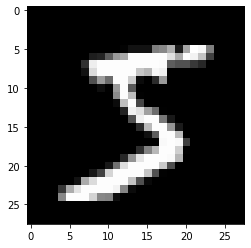

In [9]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 3


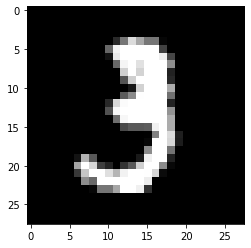

In [10]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [11]:
import torchvision.transforms as transforms 

In [12]:
# MNIST dataset (images and labels)
# convert these images into tensors as we load them
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())

In [13]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now converted to a 1x28x28 tensor. The first dimension tracks color channels. The second and third dimensions represent pixels along the height and width of the image, respectively. Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are three channels: red, green, and blue (RGB).

Let's look at some sample values inside the tensor.

In [14]:
print(img_tensor[0,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


The values range from 0 to 1, with 0 representing black, 1 white, and the values in between different shades of grey. We can also plot the tensor as an image using `plt.imshow`.

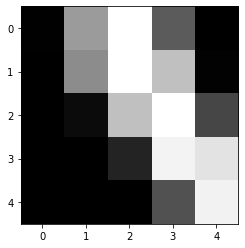

In [15]:
# Plot the image by passing in the 28 x 28 matrix
plt.imshow(img_tensor[0, 10:15, 10:15], cmap='gray');

Note that we need to pass just the 28x28 matrix to plt.imshow, without a channel dimension. We also pass a color map (cmap=gray) to indicate that we want to see a grayscale image.

## Training and Validation Datasets
While building real-world machine learning models, it is quite common to split the dataset into three parts:

* Training set - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
* Validation set - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
*  Test set - used to compare different models or approaches and report the model's final accuracy.

In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images.

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the random_spilt method from PyTorch.

In [16]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

It's essential to choose a random sample for creating a validation set. Training data is often sorted by the target labels, i.e., images of 0s, followed by 1s, followed by 2s, etc. If we create a validation set using the last 20% of images, it would only consist of 8s and 9s. In contrast, the training set would contain no 8s or 9s. Such a training-validation would make it impossible to train a useful model.

We can now create data loaders to help us load the data in batches. We'll use a batch size of 128.

In [17]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

We set shuffle=True for the training data loader to ensure that the batches generated in each epoch are different. This randomization helps generalize & speed up the training process. On the other hand, since the validation data loader is used only for evaluating the model, there is no need to shuffle the images.

## Model
Now that we have prepared our data loaders, we can define our model.

* A logistic regression model is almost identical to a linear regression model. It contains weights and bias matrices, and the output is obtained using simple matrix operations (pred = x @ w.t() + b).

* As we did with linear regression, we can use nn.Linear to create the model instead of manually creating and initializing the matrices.

* Since nn.Linear expects each training example to be a vector, each 1x28x28 image tensor is flattened into a vector of size 784 (28*28) before being passed into the model.

* The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is simply the one with the highest probability

In [18]:
import torch.nn as nn

input_size = 28 * 28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

Let's take a look at the weights and biases.

In [19]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-0.0036,  0.0348, -0.0261,  ..., -0.0192, -0.0263, -0.0025],
        [-0.0317, -0.0162,  0.0256,  ..., -0.0341, -0.0136, -0.0187],
        [-0.0006,  0.0060,  0.0263,  ...,  0.0178,  0.0011,  0.0261],
        ...,
        [-0.0054, -0.0237,  0.0228,  ...,  0.0264, -0.0222, -0.0124],
        [-0.0101,  0.0064, -0.0152,  ..., -0.0353, -0.0117, -0.0254],
        [ 0.0090, -0.0175, -0.0069,  ..., -0.0229,  0.0004, -0.0017]],
       requires_grad=True)

In [20]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0282, -0.0040,  0.0177, -0.0349,  0.0023, -0.0287, -0.0017, -0.0240,
         0.0138, -0.0122], requires_grad=True)

Although there are a total of 7850 parameters here, conceptually, nothing has changed so far. Let's try and generate some outputs using our model. We'll take the first batch of 100 images from our dataset and pass them into our model.

In [21]:
for images, labels in train_loader:
  print(labels)
  print(images.shape)
  # outputs = model(images)
  # print(outputs)
  break

tensor([3, 3, 6, 0, 1, 5, 9, 1, 6, 8, 8, 2, 4, 8, 9, 2, 1, 9, 0, 5, 7, 0, 7, 0,
        7, 7, 7, 0, 2, 0, 9, 0, 9, 0, 4, 5, 2, 5, 1, 2, 0, 2, 2, 0, 5, 1, 5, 7,
        7, 1, 0, 3, 0, 4, 8, 5, 1, 1, 6, 0, 9, 4, 2, 5, 2, 4, 7, 1, 6, 4, 6, 6,
        4, 5, 9, 0, 7, 1, 9, 6, 5, 7, 3, 6, 6, 6, 2, 9, 4, 7, 2, 8, 3, 6, 6, 0,
        5, 0, 5, 6, 9, 6, 8, 3, 9, 8, 8, 7, 7, 2, 1, 5, 1, 0, 7, 6, 0, 6, 0, 2,
        7, 6, 1, 0, 2, 8, 7, 0])
torch.Size([128, 1, 28, 28])


In [22]:
images.shape

torch.Size([128, 1, 28, 28])

In [23]:
images.reshape(128, 784).shape

torch.Size([128, 784])

The code above leads to an error because our input data does not have the right shape. Our images are of the shape 1x28x28, but we need them to be vectors of size 784, i.e., we need to flatten them. We'll use the .reshape method of a tensor, which will allow us to efficiently 'view' each image as a flat vector without really creating a copy of the underlying data. To include this additional functionality within our model, we need to define a custom model by extending the nn.Module class from PyTorch.

 Let's extend the nn.Module class from PyTorch to define a custom model.

In [24]:
class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, xb):
    xb = xb.reshape(-1, 784)
    out = self.linear(xb)
    return out

model = MnistModel()

Inside the __init__ constructor method, we instantiate the weights and biases using nn.Linear. And inside the forward method, which is invoked when we pass a batch of inputs to the model, we flatten the input tensor and pass it into self.linear.

xb.reshape(-1, 28*28) indicates to PyTorch that we want a view of the xb tensor with two dimensions. The length along the 2nd dimension is 28*28 (i.e., 784). One argument to .reshape can be set to -1 (in this case, the first dimension) to let PyTorch figure it out automatically based on the shape of the original tensor.

Note that the model no longer has .weight and .bias attributes (as they are now inside the .linear attribute), but it does have a .parameters method that returns a list containing the weights and bias.

In [25]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [26]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[-0.0235,  0.0303,  0.0130,  ..., -0.0155, -0.0173, -0.0170],
         [ 0.0167, -0.0220, -0.0041,  ...,  0.0305, -0.0050,  0.0037],
         [-0.0067, -0.0165, -0.0118,  ..., -0.0230, -0.0156, -0.0001],
         ...,
         [ 0.0310, -0.0250,  0.0273,  ..., -0.0175, -0.0327, -0.0073],
         [ 0.0214,  0.0130,  0.0187,  ..., -0.0098, -0.0010, -0.0317],
         [ 0.0204,  0.0307, -0.0090,  ...,  0.0309,  0.0325,  0.0173]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0124,  0.0098,  0.0356,  0.0313,  0.0203, -0.0304,  0.0095, -0.0229,
         -0.0319,  0.0278], requires_grad=True)]

We can use our new custom model in the same way as before. Let's see if it works.

In [27]:
for images, labels in train_loader:
  print(images.shape)
  outputs = model(images)
  break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.2766,  0.0252,  0.1503, -0.0929, -0.1604, -0.1436, -0.1538, -0.1228,
         -0.0461,  0.0319],
        [ 0.0543, -0.2654,  0.0870, -0.2897, -0.1548, -0.1251,  0.1297, -0.1255,
          0.2480,  0.0454]])


For each of the 100 input images, we get 10 outputs, one for each class. As discussed earlier, we'd like these outputs to represent probabilities. Each output row's elements must lie between 0 to 1 and add up to 1, which is not the case.

To convert the output rows into probabilities, we use the softmax function,

Then, we divide them by their sum to ensure that they add up to 1. The resulting vector can thus be interpreted as probabilities.

While it's easy to implement the softmax function, we'll use the implementation that's provided within PyTorch because it works well with multidimensional tensors (a list of output rows in our case).

In [28]:
import torch.nn.functional as F

The softmax function is included in the torch.nn.functional package and requires us to specify a dimension along which the function should be applied.

In [29]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum:", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.1337, 0.1040, 0.1178, 0.0924, 0.0863, 0.0878, 0.0869, 0.0897, 0.0968,
         0.1047],
        [0.1083, 0.0787, 0.1119, 0.0768, 0.0879, 0.0905, 0.1168, 0.0905, 0.1314,
         0.1073]])
Sum: 1.0


Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. We can do this using torch.max, which returns each row's largest element and the corresponding index.

In [30]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([0, 8, 0, 0, 8, 2, 5, 2, 2, 2, 9, 2, 0, 2, 2, 0, 8, 2, 0, 9, 0, 2, 8, 0,
        9, 9, 8, 2, 2, 2, 2, 0, 6, 0, 2, 0, 0, 2, 0, 0, 9, 9, 8, 2, 0, 2, 8, 6,
        9, 1, 0, 2, 0, 9, 0, 9, 2, 9, 0, 0, 2, 2, 9, 0, 9, 3, 2, 0, 9, 2, 2, 9,
        4, 9, 0, 9, 0, 2, 0, 9, 8, 2, 2, 0, 2, 0, 0, 2, 9, 0, 0, 2, 0, 0, 0, 9,
        2, 8, 0, 4, 9, 9, 0, 9, 9, 0, 2, 2, 0, 2, 2, 2, 2, 9, 0, 2, 5, 2, 0, 2,
        9, 4, 0, 6, 9, 9, 9, 4])
tensor([0.1337, 0.1314, 0.1415, 0.1411, 0.1194, 0.1433, 0.1242, 0.1176, 0.1275,
        0.1394, 0.1269, 0.1401, 0.1681, 0.1183, 0.1291, 0.1172, 0.1523, 0.1180,
        0.1243, 0.1295, 0.1359, 0.1306, 0.1347, 0.1314, 0.1231, 0.1365, 0.1240,
        0.1216, 0.1099, 0.1270, 0.1392, 0.1199, 0.1383, 0.1520, 0.1216, 0.1340,
        0.1206, 0.1172, 0.1192, 0.1554, 0.1248, 0.1186, 0.1164, 0.1247, 0.1721,
        0.1294, 0.1237, 0.1116, 0.1302, 0.1327, 0.1451, 0.1425, 0.1182, 0.1316,
        0.1368, 0.1354, 0.1169, 0.1422, 0.1213, 0.1297, 0.1428, 0.1230, 0.1319,
       

The numbers printed above are the predicted labels for the first batch of training images. Let's compare them with the actual labels.

In [31]:
labels

tensor([6, 8, 0, 6, 0, 2, 8, 7, 3, 2, 5, 7, 5, 1, 7, 8, 8, 3, 8, 3, 1, 1, 3, 6,
        7, 2, 8, 1, 1, 1, 6, 3, 3, 0, 2, 1, 0, 8, 3, 4, 7, 8, 2, 2, 6, 7, 2, 0,
        4, 6, 6, 2, 5, 7, 0, 9, 4, 9, 9, 9, 6, 8, 5, 9, 2, 3, 0, 0, 7, 2, 2, 0,
        7, 5, 6, 2, 2, 8, 6, 7, 8, 2, 6, 6, 5, 6, 5, 1, 2, 6, 0, 1, 9, 4, 6, 9,
        3, 8, 7, 9, 7, 7, 9, 9, 8, 6, 5, 3, 1, 4, 4, 1, 2, 2, 9, 7, 7, 2, 2, 2,
        3, 1, 9, 3, 5, 5, 3, 7])

Most of the predicted labels are different from the actual labels. That's because we have started with randomly initialized weights and biases. We need to train the model, i.e., adjust the weights using gradient descent to make better predictions.

## Evaluation Metric and Loss Function
Just as with linear regression, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly, i.e,. the accuracy of the predictions.

In [32]:
outputs[:2]

tensor([[ 0.2766,  0.0252,  0.1503, -0.0929, -0.1604, -0.1436, -0.1538, -0.1228,
         -0.0461,  0.0319],
        [ 0.0543, -0.2654,  0.0870, -0.2897, -0.1548, -0.1251,  0.1297, -0.1255,
          0.2480,  0.0454]], grad_fn=<SliceBackward>)

In [33]:
torch.sum(preds == labels)

tensor(27)

In [34]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

The == operator performs an element-wise comparison of two tensors with the same shape and returns a tensor of the same shape, containing True for unequal elements and False for equal elements. Passing the result to torch.sum returns the number of labels that were predicted correctly. Finally, we divide by the total number of images to get the accuracy.

Note that we don't need to apply softmax to the outputs since its results have the same relative order. This is because e^x is an increasing function, i.e., if y1 > y2, then e^y1 > e^y2. The same holds after averaging out the values to get the softmax.

Let's calculate the accuracy of the current model on the first batch of data.

In [35]:
accuracy(outputs, labels)

tensor(0.2109)

In [36]:
probs

tensor([[0.1337, 0.1040, 0.1178,  ..., 0.0897, 0.0968, 0.1047],
        [0.1083, 0.0787, 0.1119,  ..., 0.0905, 0.1314, 0.1073],
        [0.1415, 0.0890, 0.0987,  ..., 0.0883, 0.1033, 0.1174],
        ...,
        [0.1058, 0.0998, 0.1026,  ..., 0.0934, 0.0932, 0.1413],
        [0.1159, 0.0908, 0.1368,  ..., 0.0771, 0.0950, 0.1372],
        [0.0790, 0.0898, 0.0968,  ..., 0.0960, 0.0865, 0.1148]],
       grad_fn=<SoftmaxBackward>)

Unlike accuracy, cross-entropy is a continuous and differentiable function. It also provides useful feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). These two factors make cross-entropy a better choice for the loss function.

As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross-entropy as part of the torch.nn.functional package. Moreover, it also performs softmax internally, so we can directly pass in the model's outputs without converting them into probabilities.

In [37]:
outputs

tensor([[ 0.2766,  0.0252,  0.1503,  ..., -0.1228, -0.0461,  0.0319],
        [ 0.0543, -0.2654,  0.0870,  ..., -0.1255,  0.2480,  0.0454],
        [ 0.3502, -0.1131, -0.0102,  ..., -0.1212,  0.0354,  0.1634],
        ...,
        [ 0.0914,  0.0330,  0.0605,  ..., -0.0334, -0.0353,  0.3806],
        [ 0.1718, -0.0723,  0.3381,  ..., -0.2352, -0.0265,  0.3411],
        [-0.1654, -0.0366,  0.0379,  ...,  0.0298, -0.0742,  0.2085]],
       grad_fn=<AddmmBackward>)

In [38]:
loss_fn = F.cross_entropy

In [39]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.2861, grad_fn=<NllLossBackward>)


We know that cross-entropy is the negative logarithm of the predicted probability of the correct label averaged over all training samples. Therefore, one way to interpret the resulting number e.g. 2.23 is look at e^-2.23 which is around 0.1 as the predicted probability of the correct label, on average. The lower the loss, The better the model.

## Training the model
Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:



```
for epoch in range(num_epochs):
  # Training phase
  for batch in train_loader:
    # Generate predictions
    # Calculate loss
    # Compute gradients
    # Update weights
    # Reset gradients

  # Validation phase
  for batch in val_loader:
    # Generate predicions
    # Calculate loss
    # Calculate metrics (accuracy etc.)
  # Calculate average validation loss & metrics

  # Log epoch, loss & metrics for inspection
```

Some parts of the training loop are specific the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem.

We'll include the problem-independent parts within a function called fit, which will be used to train the model. The problem-specific parts will be implemented by adding new methods to the nn.Module class





In [40]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  optimizer = opt_func(model.parameters(), lr)
  history = [] # for recording epoch-wise results

  for epoch in range(epochs):
    # Training Phase
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Validation phase
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)

  return history

The fit function records the validation loss and metric from each epoch. It returns a history of the training, useful for debugging & visualization.

Configurations like batch size, learning rate, etc. (called hyperparameters), need to picked in advance while training machine learning models. Choosing the right hyperparameters is critical for training a reasonably accurate model within a reasonable amount of time. It is an active area of research and experimentation in machine learning. Feel free to try different learning rates and see how it affects the training process.

Let's define the evaluate function, used in the validation phase of fit.

In [41]:
l1 = [1, 2, 3, 4, 5]

In [42]:
l2 = [x*2 for x in l1]
l2

[2, 4, 6, 8, 10]

In [43]:
def evaluate (model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

Finally, let's redefine the `MnistModel` class to include additional methods training_step, validation_step, validation_epoch_end, and epoch_end used by fit and evaluate.

In [44]:
class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, xb):
    xb = xb.reshape(-1, 784)
    out = self.linear(xb)
    return out

  def training_step(self, batch):
    images, labels = batch
    out = self(images)  # Generate predictions
    loss = F.cross_entropy(out, labels)  # Calculate loss
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)   # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    acc = accuracy(out, labels)
    return {'val_loss': loss, 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()   # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = MnistModel()


Before we train the model, let's see how the model performs on the validation set with the initial set of randomly initialized weights & biases.

In [45]:
result0 = evaluate(model, val_loader)
result0

{'val_acc': 0.10334256291389465, 'val_loss': 2.3217930793762207}

The initial accuracy is around 10%, which one might expect from a randomly initialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We are now ready to train the model. Let's train for five epochs and look at the results.

In [46]:
history1 = fit(5, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 2.2774, val_acc: 0.1455
Epoch [1], val_loss: 2.2352, val_acc: 0.2147
Epoch [2], val_loss: 2.1948, val_acc: 0.2902
Epoch [3], val_loss: 2.1561, val_acc: 0.3702
Epoch [4], val_loss: 2.1188, val_acc: 0.4361


In [47]:
history2 = fit(5, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 2.0828, val_acc: 0.4868
Epoch [1], val_loss: 2.0480, val_acc: 0.5241
Epoch [2], val_loss: 2.0143, val_acc: 0.5553
Epoch [3], val_loss: 1.9818, val_acc: 0.5805
Epoch [4], val_loss: 1.9502, val_acc: 0.6004


In [48]:
history3 = fit(5, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9196, val_acc: 0.6187
Epoch [1], val_loss: 1.8899, val_acc: 0.6341
Epoch [2], val_loss: 1.8611, val_acc: 0.6499
Epoch [3], val_loss: 1.8331, val_acc: 0.6629
Epoch [4], val_loss: 1.8060, val_acc: 0.6737


In [49]:
history4 = fit(5, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.7796, val_acc: 0.6832
Epoch [1], val_loss: 1.7541, val_acc: 0.6918
Epoch [2], val_loss: 1.7293, val_acc: 0.7009
Epoch [3], val_loss: 1.7052, val_acc: 0.7076
Epoch [4], val_loss: 1.6818, val_acc: 0.7139


While the accuracy does continue to increase as we train for more epochs, the improvements get smaller with every epoch. Let's visualize this using a line graph.

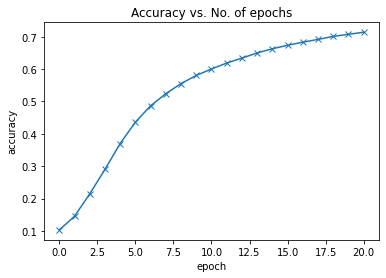

In [50]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

It's quite clear from the above picture that the model probably won't cross the accuracy threshold of 80% even after training for a very long time. One possible reason for this is that the learning rate might be too high. The model's parameters may be "bouncing" around the optimal set of parameters for the lowest loss. You can try reducing the learning rate and training for a few more epochs to see if it helps.

The more likely reason that the model just isn't powerful enough. If you remember our initial hypothesis, we have assumed that the output (in this case the class probabilities) is a linear function of the input (pixel intensities), obtained by perfoming a matrix multiplication with the weights matrix and adding the bias. This is a fairly weak assumption, as there may not actually exist a linear relationship between the pixel intensities in an image and the digit it represents. While it works reasonably well for a simple dataset like MNIST (getting us to 75% accuracy), we need more sophisticated models that can capture non-linear relationships between image pixels and labels for complex tasks like recognizing everyday objects, animals etc.

In [51]:
jovian.log_metrics(val_acc=history[-1]['val_acc'], val_loss=history[-1]['val_loss'])

[jovian] Metrics logged.


In [52]:
jovian.commit(project='logistic-regression-softmax-crossentropy', environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/monika171/logistic-regression-softmax-crossentropy


'https://jovian.ai/monika171/logistic-regression-softmax-crossentropy'

## Testing with individual images
While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by recreating the test dataset with the ToTensor transform.

In [53]:
# Define test dataset
test_dataset = MNIST(root='data/',
                     train=False,
                     transform=transforms.ToTensor())

Here's a sample image from the dataset.

Shape: torch.Size([1, 28, 28])
Label: 7


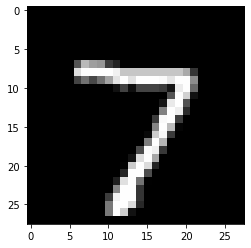

In [54]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

Let's define a helper function predict_image, which returns the predicted label for a single image tensor.

In [55]:
def predict_image(img, model):
  xb = img.unsqueeze(0)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return preds[0].item()

img.unsqueeze simply adds another dimension at the begining of the 1x28x28 tensor, making it a 1x1x28x28 tensor, which the model views as a batch containing a single image.

Let's try it out with a few images.

Label: 7 , Predicted: 7


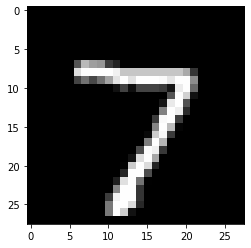

In [56]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


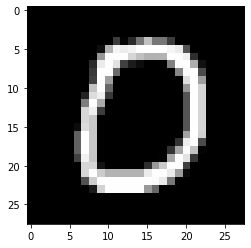

In [57]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 3


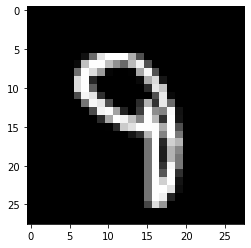

In [58]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 8


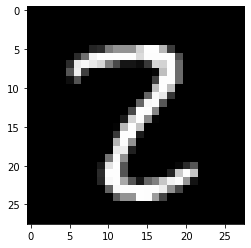

In [59]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's also look at the overall loss and accuracy of the model on the test set.

In [60]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_acc': 0.708691418170929, 'val_loss': 1.6707308292388916}

We expect this to be similar to the accuracy/loss on the validation set. If not, we might need a better validation set that has similar data and distribution as the test set (which often comes from real world data).

## Saving and loading the model
Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights and bias matrices to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.

In [61]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

The .state_dict method returns an OrderedDict containing all the weights and bias matrices mapped to the right attributes of the model.

In [62]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0133, -0.0034,  0.0314,  ...,  0.0026, -0.0170, -0.0270],
                      [-0.0184,  0.0344,  0.0060,  ..., -0.0025,  0.0268,  0.0211],
                      [ 0.0240, -0.0276,  0.0239,  ..., -0.0216, -0.0037, -0.0273],
                      ...,
                      [-0.0098,  0.0065, -0.0306,  ...,  0.0046, -0.0066,  0.0219],
                      [ 0.0217, -0.0152,  0.0200,  ...,  0.0121, -0.0086,  0.0278],
                      [-0.0327, -0.0227,  0.0009,  ..., -0.0320, -0.0019,  0.0093]])),
             ('linear.bias',
              tensor([ 0.0114,  0.0358, -0.0305, -0.0333,  0.0307, -0.0045,  0.0099, -0.0280,
                      -0.0281,  0.0237]))])

To load the model weights, we can instante a new object of the class MnistModel, and use the .load_state_dict method.


Since, notice in [63][64][65], which gives wrong result.

Correct solution [66] onward.

In [63]:
model2 = MnistModel()

In [64]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0331,  0.0002,  0.0250,  ...,  0.0094, -0.0180, -0.0064],
                      [ 0.0307,  0.0098,  0.0339,  ...,  0.0271, -0.0311, -0.0258],
                      [-0.0085, -0.0336, -0.0220,  ...,  0.0167, -0.0052, -0.0330],
                      ...,
                      [ 0.0020, -0.0257, -0.0283,  ..., -0.0081, -0.0260, -0.0201],
                      [-0.0263, -0.0151, -0.0078,  ..., -0.0072,  0.0297, -0.0034],
                      [-0.0022,  0.0158,  0.0077,  ...,  0.0277,  0.0242, -0.0200]])),
             ('linear.bias',
              tensor([-0.0109, -0.0154, -0.0052, -0.0106,  0.0292,  0.0202, -0.0055, -0.0316,
                       0.0127,  0.0177]))])

In [65]:
evaluate(model2, test_loader)

{'val_acc': 0.09189452975988388, 'val_loss': 2.3133668899536133}

In [66]:
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0133, -0.0034,  0.0314,  ...,  0.0026, -0.0170, -0.0270],
                      [-0.0184,  0.0344,  0.0060,  ..., -0.0025,  0.0268,  0.0211],
                      [ 0.0240, -0.0276,  0.0239,  ..., -0.0216, -0.0037, -0.0273],
                      ...,
                      [-0.0098,  0.0065, -0.0306,  ...,  0.0046, -0.0066,  0.0219],
                      [ 0.0217, -0.0152,  0.0200,  ...,  0.0121, -0.0086,  0.0278],
                      [-0.0327, -0.0227,  0.0009,  ..., -0.0320, -0.0019,  0.0093]])),
             ('linear.bias',
              tensor([ 0.0114,  0.0358, -0.0305, -0.0333,  0.0307, -0.0045,  0.0099, -0.0280,
                      -0.0281,  0.0237]))])

Just as a sanity check, let's verify that this model has the same loss and accuracy on the test set as before.

In [67]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_acc': 0.708691418170929, 'val_loss': 1.6707308292388916}

In [68]:
jovian.commit(project='logistic-regression-softmax-crossentropy', environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/monika171/logistic-regression-softmax-crossentropy


'https://jovian.ai/monika171/logistic-regression-softmax-crossentropy'

As a final step, we can save and commit our work using the jovian library. Along with the notebook, we can also attach the weights of our trained model, so that we can use it later.

In [70]:
jovian.commit(project='logistic-regression-softmax-crossentropy', environment=None, outputs=['mnist-logistic.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/monika171/logistic-regression-softmax-crossentropy


'https://jovian.ai/monika171/logistic-regression-softmax-crossentropy'